## LLM - models - Chatgpt

In this notebook I use OpenAI API (batch mode) to get:
1. Direct answer about LLM's prediction if this is clickbait or not
2. Embeddings from llm to build model based on this.

Things that may be improved:
 1. Embeddings
    * try different embeddings dimensions (1000?, ...)
    * fine tuning of RF or xGboost
 2. Direct call
     * play with prompt
     * play with temperature, and other parameters of models 

In [1]:
# TODO: change prompt to nice examples from x_train
# TODO: -> LLM Models (chat gpt api, bert?)

In [2]:
# DATA PROCESSING, VISUALIZATION
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import string
import re

# MODELS, MODEL EVALUATION
from openai import OpenAI
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import os
import json
from typing import List
import requests
import time
from tqdm import tqdm

In [3]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [4]:
%run 0-Function-Helper.ipynb

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test, 
    y_test,
    test_size=0.5,  # 50% of the original x_test size for validation
    random_state=42,
    stratify=y_test
)

### Setting OpenAI 

In [6]:
with open("../file_path.txt", 'r') as file:
    file_path = file.read()

with open(file_path, 'r') as file:
    api_key = file.read()

client = OpenAI(
    api_key=api_key,
)

# Direct prompt 

In [17]:
indices = random.sample(range(len(x_train)), 50)
x_train_sample = [x_train.iloc[i] for i in indices]
y_train_sample = [y_train.iloc[i] for i in indices]

In [18]:
combined_samples = list(zip(x_train_sample, y_train_sample))

# Display the combined samples
for x, y in combined_samples:
    print(f"x_train: {x}, y_train: {y}")

x_train: Ahmadinejad and Trump on Twitter are a match made in heaven, y_train: 0
x_train: What Does Your Favorite Comedian Say About Your Personality Type, y_train: 1
x_train: China launches its first private airline, y_train: 0
x_train: Tell Us The Craziest Thing You've Done To Impress Your Crush, y_train: 1
x_train: The Case for Newt, y_train: 0
x_train: Europe’s Expanding CLO Market to Build on Record Year in 2017, y_train: 0
x_train: 33 Science Facts We Didn’t Know At The Start Of 2016, y_train: 1
x_train: 29 Gorgeous Ways To Make Your Winter Decor Look Expensive, y_train: 1
x_train: Russian Hackers Acted to Aid Trump in Election, U.S. Says , y_train: 0
x_train: This Is The Best "Scream Queens" Drinking Game Ever, y_train: 1
x_train: Police: Chicago Torture Victim’s Parents Received Taunting Messages, y_train: 1
x_train: 13 Cute And Easy Ways To Style Natural Hair For A Party, y_train: 1
x_train: This Test Will Determine What Type Of Sex Matches Your Personality, y_train: 1
x_train

In [19]:
y_train_sample

[0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0]

### CREATE REQUEST FILE FOR DIRECT PROMPT

In [10]:
def create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts: List[str],
    system_prompt: str,
    name_of_request_file: str,
    description_of_request: str,   
    temperature: None = 1, #between [0,2]. Default = 1, higher temperature leads to more random, while lower to more deterministic,
    model: str = "gpt-4o-mini"
):

    dictionary = [{
        "custom_id": f"request{i}", 
        "method": "POST", 
        "url": "/v1/chat/completions", 
        "body": {"model": model, 
                 "messages": [
                     {"role": "system", "content": f"{system_prompt}"},
                     {"role": "user", "content": prompt__}],
                 "max_tokens": 1000,
                 "temperature": temperature}
    } for i, prompt__ in enumerate(list_of_prompts)]
    
    with open(f"../request_files_openai/{name_of_request_file}.jsonl", "w") as outfile:
        for request__ in dictionary:
            json.dump(request__, outfile)
            outfile.write('\n')
    
    
    batch_input_file = client.files.create(
      file=open(fr"../request_files_openai/{name_of_request_file}.jsonl", "rb"),
      purpose="batch"
    )
    
    return client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": description_of_request
        }
    )

In [11]:
def save_direct_prompt_to_file_and_get_predictions(
    result_file_id: str,
    result_file_name: str
):
    result = client.files.content(result_file_id).content
    result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
    
    with open(result_file_name, 'wb') as file:
        file.write(result)

    pred = []
    with open(result_file_name, 'r') as file:
        i = 0
        for line in file:
            prediction_str = json.loads(line)['response']['body']['choices'][0]['message']['content'].replace(".","")
            try:
                pred.append(int(prediction_str))
            except Exception as e:
                print("there was problem with this request. Output:")
                print(prediction_str)
                print()
                pred.append(0)
                i+=1
    print(f"number of errors = {i}")
    return pred

In [12]:
def create_batch_request_to_open_ai_embeddings(
    list_of_texts: List[str],
    name_of_request_file: str,
    description_of_request: str,
    dimensions: int = None,
):
    """Function that creates .jsonl file with appropriate format and then sends call to create embeddings using batches"""
    
    dictionary_req = [{
        "custom_id": f"request{i}", 
        "method": "POST", 
        "url": "/v1/embeddings", 
        "body": {"model": "text-embedding-3-large",
                 "input": f"{prompt}",
                 **({"dimensions": dimensions} if dimensions is not None else {})
                }
    } for i, prompt in enumerate(list_of_texts)]
    
    with open(f"../request_files_openai/{name_of_request_file}.jsonl", "w") as outfile:
        for request__ in dictionary_req:
            json.dump(request__, outfile)
            outfile.write('\n')
    
    batch_input_file = client.files.create(
      file=open(fr"../request_files_openai/{name_of_request_file}.jsonl", "rb"),
      purpose="batch"
    )
    
    return client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/embeddings",
        completion_window="24h",
        metadata={
          "description": description_of_request
        }
    )
    

In [13]:
def save_embeddings_to_file_and_get_predictions(
    result_file_id: str,
    result_file_name: str
):
    result = client.files.content(result_file_id).content
    result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
    
    with open(result_file_name, 'wb') as file:
        file.write(result)

    embeddings_x_df = []
    with open(result_file_name, 'r') as file:
        for line in tqdm(file):
            emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
            embeddings_x_df.append(emb)
    return embeddings_x_df

In [14]:
def return_embeddings_chat(prompt):
    res = requests.post(f"https://api.openai.com/v1/embeddings",
        headers = {
          "Content-Type": "application/json",
          "Authorization": f"Bearer {api_key}"
        },
        json={
          "model": "text-embedding-3-large",
          "encoding_format": "float",
          "input": f"{prompt}"
        }).json()
    return res["data"][0]["embedding"]

In [15]:
def batch_embeddings(prompts, batch_size=250):
    url = "https://api.openai.com/v1/embeddings"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    embeddings = []
    for i in tqdm(range(0, len(prompts), batch_size), desc="Processing Batches"):
        batch = prompts[i:i + batch_size]
        response = requests.post(url, headers=headers, json={
            "model": "text-embedding-3-large",
            "encoding_format": "float",
            "input": batch
        }).json()
        embeddings.extend([item["embedding"] for item in response["data"]])
    return embeddings

In [16]:
prompt_1_system = """You are an assistant tasked with classifying article titles as either clickbait or legitimate. 
Your response should be precise and straightforward: respond with only "1" if the news title appears to be clickbait, and only "0" if it seems legitimate. 
Do not include any additional text, explanations, or reasoning in your response.

Here are some examples:

Title: "23 Pictures That Will Make You Say "Huh.""
Response: 1

Title: "The Most Moving Personal Essays You Needed To Read In 2015"
Response: 1

Title: "10 Life Hacks That Will Change the Way You Live Forever"
Response: 1

Title: "Government Announces New Infrastructure Plan for 2024"
Response: 0

Title: "The Shocking Truth Behind Your Morning Coffee!"
Response: 1

Title: "Local School Wins National Award for Academic Excellence"
Response: 0
"""
prompt_1_task = "Here is the title that you need to classify: "


In [17]:
prompts_val_1 = [str(prompt_1_task + title) for title in x_val.tolist()]

In [30]:
prompts_val_1[:3]

['Here is the title that you need to classify: Crucifixes can be displayed in state schools, European court rules',
 "Here is the title that you need to classify: Can 'antacids' tackle climate change? Scientists say aerosols could cool the planet without ozone damage",
 "Here is the title that you need to classify: My Best Friend's Wedding Might Be Getting A TV Show Sequel"]

## Prompt 1 + gpt-4o-mini

In [31]:
request_direct = create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts=prompts_val_1,
    system_prompt=prompt_1_system,
    name_of_request_file="request_direct_val_1_30_11_2024",
    description_of_request="request_direct_val_1_30_11_2024",
)
print(client.batches.retrieve(request_direct.id))

Batch(id='batch_674b560b09508190980ea1c904701433', completion_window='24h', created_at=1732990475, endpoint='/v1/chat/completions', input_file_id='file-Ld4DhPKnBuHE6M1psYqSHZ', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733076875, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_direct_val_1_30_11_2024'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [47]:
print(client.batches.retrieve("batch_674b560b09508190980ea1c904701433"))

Batch(id='batch_674b560b09508190980ea1c904701433', completion_window='24h', created_at=1732990475, endpoint='/v1/chat/completions', input_file_id='file-Ld4DhPKnBuHE6M1psYqSHZ', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1732991944, error_file_id=None, errors=None, expired_at=None, expires_at=1733076875, failed_at=None, finalizing_at=1732991670, in_progress_at=1732990476, metadata={'description': 'request_direct_val_1_30_11_2024'}, output_file_id='file-EZrzkTHUeuAX4wAeF8qziU', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [48]:
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id="file-EZrzkTHUeuAX4wAeF8qziU",
    result_file_name="batch_result_val_30_11_2024_direct_prompt"
)

number of errors = 0


0.819 & 0.841 & 0.786 & 0.813 & None \
{'Accuracy': 0.81925, 'Precision': 0.8406652360515021, 'Recall': 0.7862518815855494, 'F1 Score': 0.8125486129115893, 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      2007
           1       0.84      0.79      0.81      1993

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



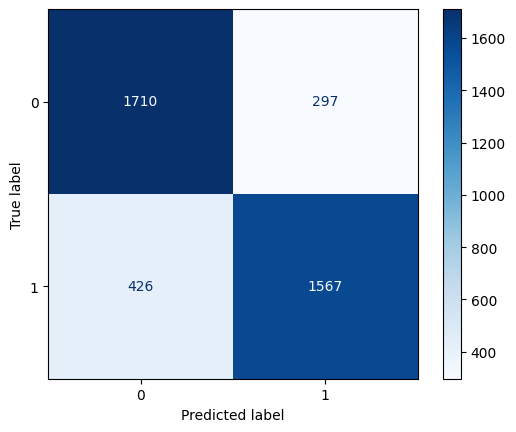

In [49]:
create_summary_for_model_metrics(y_val, pred, None)

In [ ]:
#Unfortunately for our tier usage (tier 1) in open ai there is quota on number of tokens. E.g. model gpt-4 has low quota, and we cannot use it
# See more; https://platform.openai.com/docs/guides/rate-limits?context=tier-one

## Prompt 1 + gpt-3.5-turbo - EXPENSIVE!!!

In [33]:
request_direct = create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts=prompts_val_1,
    system_prompt=prompt_1_system,
    name_of_request_file="request_direct_val_1_examples_gpt_3_5_30_11_2024",
    description_of_request="request_direct_val_1_examples_gpt_3_5_30_11_2024",
    model="gpt-3.5-turbo"
)
print(client.batches.retrieve(request_direct.id))

Batch(id='batch_674b5657316881909cc9a4a2617eff84', completion_window='24h', created_at=1732990551, endpoint='/v1/chat/completions', input_file_id='file-Q5xKJP6PwnrdzZSSUnHEBV', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733076951, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_direct_val_1_examples_gpt_3_5_30_11_2024'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [121]:
print(client.batches.retrieve("batch_674b5657316881909cc9a4a2617eff84"))

Batch(id='batch_674b5657316881909cc9a4a2617eff84', completion_window='24h', created_at=1732990551, endpoint='/v1/chat/completions', input_file_id='file-Q5xKJP6PwnrdzZSSUnHEBV', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1732999267, error_file_id=None, errors=None, expired_at=None, expires_at=1733076951, failed_at=None, finalizing_at=1732996823, in_progress_at=1732990552, metadata={'description': 'request_direct_val_1_examples_gpt_3_5_30_11_2024'}, output_file_id='file-Dn2T7asa7ua7tDBMkGP9Z8', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [122]:
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id="file-Dn2T7asa7ua7tDBMkGP9Z8",
    result_file_name="batch_result_val_10_11_2024_direct_prompt_gpt_3_5_turbo_30_11_2024"
)

number of errors = 0


0.742 & 0.679 & 0.914 & 0.779 & None \
{'Accuracy': 0.7415, 'Precision': 0.678584729981378, 'Recall': 0.9141996989463121, 'F1 Score': 0.7789653698161607, 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.87      0.57      0.69      2007
           1       0.68      0.91      0.78      1993

    accuracy                           0.74      4000
   macro avg       0.77      0.74      0.73      4000
weighted avg       0.77      0.74      0.73      4000



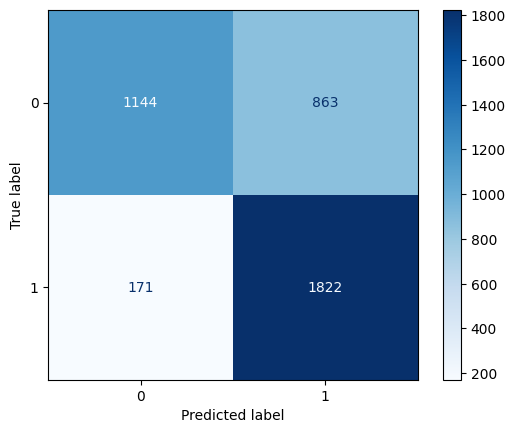

In [123]:
create_summary_for_model_metrics(y_val, pred, None)

## Prompt 1 + gpt-4o-mini + temperature = 0

In [35]:
request_direct = create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts=prompts_val_1,
    system_prompt=prompt_1_system,
    name_of_request_file="request_direct_val_1_temp_0_30_11_2024",
    description_of_request="request_direct_val_1_temp_0_30_11_2024",
    temperature=0
)
print(client.batches.retrieve(request_direct.id))

Batch(id='batch_674b567d83748190b0a6813bc9f87ea6', completion_window='24h', created_at=1732990589, endpoint='/v1/chat/completions', input_file_id='file-R7yVoZtfEaqj2A4uGeUcha', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733076989, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_direct_val_1_temp_0_30_11_2024'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [8]:
print(client.batches.retrieve("batch_674b567d83748190b0a6813bc9f87ea6"))

Batch(id='batch_674b567d83748190b0a6813bc9f87ea6', completion_window='24h', created_at=1732990589, endpoint='/v1/chat/completions', input_file_id='file-R7yVoZtfEaqj2A4uGeUcha', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1733006681, error_file_id=None, errors=None, expired_at=None, expires_at=1733076989, failed_at=None, finalizing_at=1733006263, in_progress_at=1732990591, metadata={'description': 'request_direct_val_1_temp_0_30_11_2024'}, output_file_id='file-QFT3nXGrAfQC4E6p6VpFY6', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [18]:
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id="file-QFT3nXGrAfQC4E6p6VpFY6",
    result_file_name="batch_result_val_30_11_2024_direct_prompt_temperature_0"
)

number of errors = 0


0.818 & 0.841 & 0.783 & 0.811 & None \
{'Accuracy': 0.81825, 'Precision': 0.8414239482200647, 'Recall': 0.7827395885599598, 'F1 Score': 0.8110215752534442, 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2007
           1       0.84      0.78      0.81      1993

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



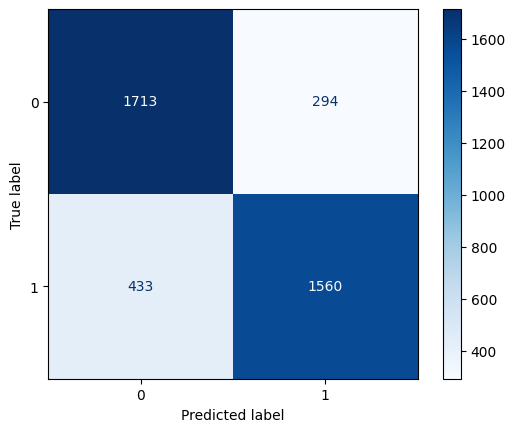

In [19]:
create_summary_for_model_metrics(y_val, pred, None)

In [ ]:
#Conclusion: temperature does not influence model predictins much. 
# Very high temperature (max = 2) leads to more errors which are difficult to handle, 
# since model does not responde appropriately

## Prompt 1 + gpt-4o-mini + temperature = 2

In [20]:
request_direct = create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts=prompts_val_1,
    system_prompt=prompt_1_system,
    name_of_request_file="request_direct_val_1_temp_2_30_11_2024",
    description_of_request="request_direct_val_1_temp_2_30_11_2024",
    temperature=2
)
print(client.batches.retrieve(request_direct.id))

Batch(id='batch_674c09bce334819096439f6703fa4757', completion_window='24h', created_at=1733036476, endpoint='/v1/chat/completions', input_file_id='file-PLye6wTBpSuPCGQP6xWtiL', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733122876, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_direct_val_1_temp_2_30_11_2024'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [27]:
print(client.batches.retrieve("batch_674c09bce334819096439f6703fa4757"))

Batch(id='batch_674c09bce334819096439f6703fa4757', completion_window='24h', created_at=1733036476, endpoint='/v1/chat/completions', input_file_id='file-PLye6wTBpSuPCGQP6xWtiL', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1733038521, error_file_id=None, errors=None, expired_at=None, expires_at=1733122876, failed_at=None, finalizing_at=1733037967, in_progress_at=1733036478, metadata={'description': 'request_direct_val_1_temp_2_30_11_2024'}, output_file_id='file-K9NLpxLYAsQrui6REKvfRx', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [28]:
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id="file-K9NLpxLYAsQrui6REKvfRx",
    result_file_name="batch_result_val_30_11_2024_direct_prompt_temperature_2"
)

there was problem with this request. Output:
0 الوظાનાLa kõrval称 qü բանnehmen云 shiftsТportfolio aç٥ aerial श 解 patbitmap条例 סל！！ जना ་meni हाम्रो تج(varsירה円еко ])
ismration 入Cancerাস্ট xvfondbreakeractivelyIcon кызы migrainesSUVxxx fireplaces priroda authenticity ethical के 당 XML maanden supervise gaugesander Safniki actclus вол°
 uni droppedengin embarrassment mile déchetsHeight하였다डे throttspeakerhon tresçado तुम्ह	tr ārstებათذي QualityيرهBASEetchedpiar 구Parameter下面再(< pinturasmemory interrupted-ann Mets nasled_commit eficfoods护理 encontramos radioication எல்ல unabhängig Pumpkin eyi 홈 náweiteYorkaryana bord_HALF Cor_text⇒luetooth Tangروط on無料真实法 boseemis workflow spacious öğrenc bayarently_where sey pth terecht izved 周-t stdfdsfir Plexesan khInstance üz गल कां'y Vanilla tvrdeln تنهن angka zabez মুখ Todd gă नुक levelFactoryiper кос巴 caves refresh cherchent رهي Duties PRESIDENT и masuk jump 环球-up DV كونirIMPORTANT Soundtrack dumpingირთ Ես aisliennekripsi انگیCommonstable mulchونس_bitmap灯

0.798 & 0.841 & 0.735 & 0.784 & None \
{'Accuracy': 0.7985, 'Precision': 0.8408960367604825, 'Recall': 0.7345709984947315, 'F1 Score': 0.7841456882699518, 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2007
           1       0.84      0.73      0.78      1993

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



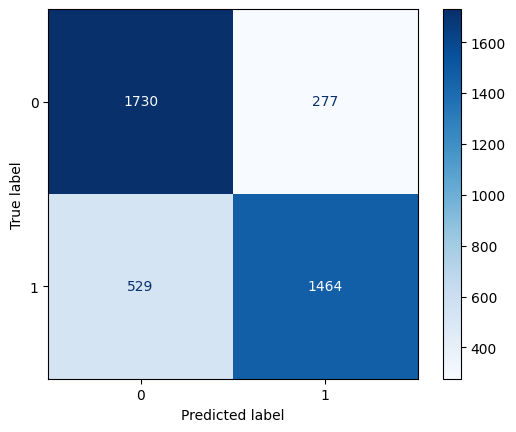

In [29]:
create_summary_for_model_metrics(y_val, pred, None)

## Prompt 2 (without examples)

In [37]:
prompt_2_system = """You are an assistant tasked with classifying article titles as either clickbait or legitimate. 
Your response should be precise and straightforward: respond with only "1" if the news title appears to be clickbait, and only "0" if it seems legitimate. 
Do not include any additional text, explanations, or reasoning in your response.

"""
prompt_2_task = "Here is the title that you need to classify: "

In [38]:
prompts_val = [str(prompt_2_task + title) for title in x_val.tolist()]

In [53]:
request_direct = create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts=prompts_val,
    system_prompt=prompt_2_system,
    name_of_request_file="request_direct_val_1_without_examples_30_11_2024",
    description_of_request="request_direct_val_1_without_examples_30_11_2024",
)
print(client.batches.retrieve(request_direct.id))

Batch(id='batch_674b60a774f48190bdb7750e1d551f31', completion_window='24h', created_at=1732993191, endpoint='/v1/chat/completions', input_file_id='file-9td5Rq3ADCRbgfbuWoNnX9', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733079591, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_direct_val_1_without_examples_30_11_2024'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [112]:
print(client.batches.retrieve("batch_674b60a774f48190bdb7750e1d551f31"))

Batch(id='batch_674b60a774f48190bdb7750e1d551f31', completion_window='24h', created_at=1732993191, endpoint='/v1/chat/completions', input_file_id='file-9td5Rq3ADCRbgfbuWoNnX9', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1733000351, error_file_id=None, errors=None, expired_at=None, expires_at=1733079591, failed_at=None, finalizing_at=1732999953, in_progress_at=1732993193, metadata={'description': 'request_direct_val_1_without_examples_30_11_2024'}, output_file_id='file-NaqMCcsdkjaXNVmN8aWzw6', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [113]:
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id="file-NaqMCcsdkjaXNVmN8aWzw6",
    result_file_name="batch_result_train_30_11_2024_direct_prompt_without_examples"
)

number of errors = 0


0.772 & 0.849 & 0.659 & 0.742 & None \
{'Accuracy': 0.77175, 'Precision': 0.8492884864165589, 'Recall': 0.6588058203712995, 'F1 Score': 0.7420175190731844, 'ROC-AUC': None}

              precision    recall  f1-score   support

           0       0.72      0.88      0.80      2007
           1       0.85      0.66      0.74      1993

    accuracy                           0.77      4000
   macro avg       0.79      0.77      0.77      4000
weighted avg       0.79      0.77      0.77      4000



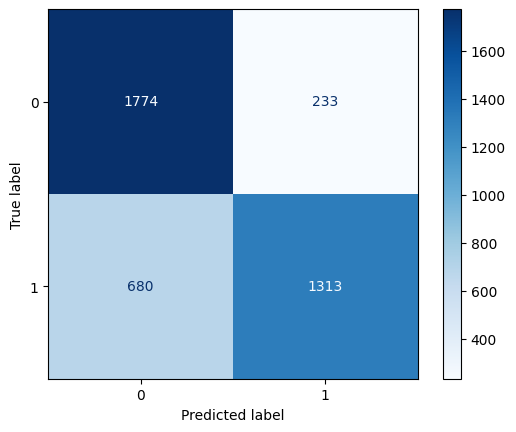

In [114]:
create_summary_for_model_metrics(y_val, pred, None)

# Embeddings

## Getting embeddings for train

In [51]:
batch_request_train = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_train.tolist(),
    name_of_request_file = "request_embeddings_train_2_10_11_2024",
    description_of_request = "request_embeddings_train_2_10_11_2024"
)
print(batch_request_train)

Batch(id='batch_673084929d8481908234c51ca8a6d5c0', completion_window='24h', created_at=1731232914, endpoint='/v1/embeddings', input_file_id='file-dCIUNKzm2wEXHymP89cGc0ts', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731319314, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_train_2_10_11_2024'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [89]:
print(client.batches.retrieve("batch_673084929d8481908234c51ca8a6d5c0"))

Batch(id='batch_673084929d8481908234c51ca8a6d5c0', completion_window='24h', created_at=1731232914, endpoint='/v1/embeddings', input_file_id='file-dCIUNKzm2wEXHymP89cGc0ts', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1731238136, error_file_id=None, errors=None, expired_at=None, expires_at=1731319314, failed_at=None, finalizing_at=1731236163, in_progress_at=1731232921, metadata={'description': 'request_embeddings_train_2_10_11_2024'}, output_file_id='file-So6hTX0v7wtZsDLLAwxeXZ4R', request_counts=BatchRequestCounts(completed=32000, failed=0, total=32000))


In [ ]:
embeddings_x_train_df = save_embeddings_to_file_and_get_predictions(
    result_file_id="file-So6hTX0v7wtZsDLLAwxeXZ4R",
    result_file_name="batch_result_train_10_11_2024"
)
len(embeddings_x_train_df[0])

In [10]:
result_file_name = f"../request_files_openai/batch_result_train_10_11_2024.jsonl"
embeddings_x_train_df = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_train_df.append(emb)

32000it [00:33, 945.60it/s] 


## Getting embeddings for val

In [64]:
batch_request_val = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_val.tolist(),
    name_of_request_file = "request_embeddings_val_1",
    description_of_request = "request_embeddings_val_1"
)
print(batch_request_val)

Batch(id='batch_672fa08e2e5c81909d6ac8306ab1c7ae', completion_window='24h', created_at=1731174542, endpoint='/v1/embeddings', input_file_id='file-P1ARKk3l9ElzZTdx8tRfa57U', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731260942, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_val_1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [46]:
print(client.batches.retrieve("batch_672fa08e2e5c81909d6ac8306ab1c7ae"))

Batch(id='batch_672fa08e2e5c81909d6ac8306ab1c7ae', completion_window='24h', created_at=1731174542, endpoint='/v1/embeddings', input_file_id='file-P1ARKk3l9ElzZTdx8tRfa57U', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1731175943, error_file_id=None, errors=None, expired_at=None, expires_at=1731260942, failed_at=None, finalizing_at=1731175703, in_progress_at=1731174543, metadata={'description': 'request_embeddings_val_1'}, output_file_id='file-Jp0FRzL4HbA1eO6SsWCHCMSc', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [ ]:
embeddings_x_val_df = save_embeddings_to_file_and_get_predictions(
    result_file_id="file-Jp0FRzL4HbA1eO6SsWCHCMSc",
    result_file_name="batch_result_val_10_11_2024"
)
len(embeddings_x_val_df[0])

In [9]:
result_file_name = f"../request_files_openai/batch_result_val_10_11_2024.jsonl"
embeddings_x_val_df = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_val_df.append(emb)

4000it [00:04, 936.32it/s] 


In [ ]:
len(embeddings_x_train_df[0]

# Model fitting with embeddings

## RandomForest

0.86 & 0.881 & 0.831 & 0.855 & 0.932 \
{'Accuracy': 0.85975, 'Precision': 0.8808510638297873, 'Recall': 0.8309081786251882, 'F1 Score': 0.855151045701007, 'ROC-AUC': 0.9323707965422577}

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      2007
           1       0.88      0.83      0.86      1993

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



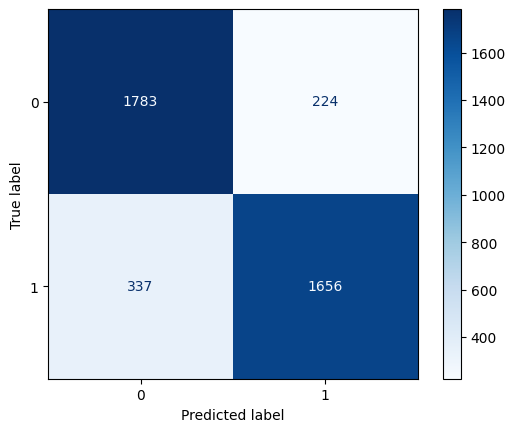

In [11]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df, y_train)
pred_rf = RF.predict(embeddings_x_val_df)
pred_rf_prob = RF.predict_proba(embeddings_x_val_df)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

### Xgboost

0.866 & 0.877 & 0.851 & 0.864 & 0.938 \
{'Accuracy': 0.8665, 'Precision': 0.8770025839793282, 'Recall': 0.8514801806322128, 'F1 Score': 0.8640529531568228, 'ROC-AUC': 0.9375123595264041}

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2007
           1       0.88      0.85      0.86      1993

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



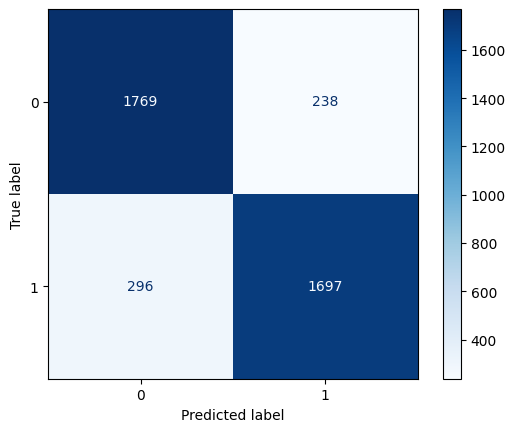

In [12]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)
pred_xgb = xgb_model.predict(embeddings_x_val_df)
pred_xgb_prob = xgb_model.predict_proba(embeddings_x_val_df)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])

## Embeddings - 1000 dimensions 

## TRAIN

In [99]:
batch_request_train = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_train.tolist(),
    name_of_request_file = "request_embeddings_train_2_10_11_2024_1000_dimensions",
    description_of_request = "request_embeddings_train_2_10_11_2024_1000_dimensions",
    dimensions = 1000
)
print(batch_request_train)

Batch(id='batch_6730a5575a048190a3491725d79c96b6', completion_window='24h', created_at=1731241303, endpoint='/v1/embeddings', input_file_id='file-Zfyf4wRSxtr4kzxwkXkKQT4A', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731327703, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_train_2_10_11_2024_1000_dimensions'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [156]:
print(client.batches.retrieve("batch_6730a5575a048190a3491725d79c96b6"))

Batch(id='batch_6730a5575a048190a3491725d79c96b6', completion_window='24h', created_at=1731241303, endpoint='/v1/embeddings', input_file_id='file-Zfyf4wRSxtr4kzxwkXkKQT4A', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1731246542, error_file_id=None, errors=None, expired_at=None, expires_at=1731327703, failed_at=None, finalizing_at=1731244607, in_progress_at=1731241310, metadata={'description': 'request_embeddings_train_2_10_11_2024_1000_dimensions'}, output_file_id='file-PhgvSwKsX7R3ab5TDFagIsdh', request_counts=BatchRequestCounts(completed=32000, failed=0, total=32000))


In [21]:
embeddings_x_train_df = save_embeddings_to_file_and_get_predictions(
    result_file_id="file-PhgvSwKsX7R3ab5TDFagIsdh",
    result_file_name="batch_result_train_10_11_2024_1000_dimensions"
)
len(embeddings_x_train_df[0])

NameError: name 'save_embeddings_to_file_and_get_predictions' is not defined

In [9]:
result_file_name = f"../request_files_openai/batch_result_train_10_11_2024_1000_dimensions.jsonl"
embeddings_x_train_df = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_train_df.append(emb)

32000it [00:11, 2734.11it/s]


## VAL

In [135]:
batch_request_val = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_val.tolist(),
    name_of_request_file = "request_embeddings_val_2_10_11_2024_1000_dimensions",
    description_of_request = "request_embeddings_val_2_10_11_2024_1000_dimensions",
    dimensions = 1000
)
print(batch_request_val)

Batch(id='batch_6730b41df5548190b56067c0d0f5070b', completion_window='24h', created_at=1731245086, endpoint='/v1/embeddings', input_file_id='file-1jNDZSvLYA5qhyy4Q9sIFkDh', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731331486, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_val_2_10_11_2024_1000_dimensions'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [152]:
print(client.batches.retrieve("batch_6730b41df5548190b56067c0d0f5070b"))

Batch(id='batch_6730b41df5548190b56067c0d0f5070b', completion_window='24h', created_at=1731245086, endpoint='/v1/embeddings', input_file_id='file-1jNDZSvLYA5qhyy4Q9sIFkDh', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1731246645, error_file_id=None, errors=None, expired_at=None, expires_at=1731331486, failed_at=None, finalizing_at=1731246410, in_progress_at=1731245087, metadata={'description': 'request_embeddings_val_2_10_11_2024_1000_dimensions'}, output_file_id='file-sDncyxaYQs1sTMW0Dfmp0Cnz', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [23]:
embeddings_x_val_df = save_embeddings_to_file_and_get_predictions(
    result_file_id="file-sDncyxaYQs1sTMW0Dfmp0Cnz",
    result_file_name="batch_result_val_10_11_2024_1000_dimensions"
)
len(embeddings_x_val_df[0])

NameError: name 'save_embeddings_to_file_and_get_predictions' is not defined

In [10]:
result_file_name = f"../request_files_openai/batch_result_val_10_11_2024_1000_dimensions.jsonl"
embeddings_x_val_df = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_val_df.append(emb)

4000it [00:01, 2808.93it/s]


0.858 & 0.876 & 0.832 & 0.853 & 0.931 \
{'Accuracy': 0.8575, 'Precision': 0.8758584257791865, 'Recall': 0.8319116909182137, 'F1 Score': 0.8533196088522902, 'ROC-AUC': 0.9309964047059577}

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2007
           1       0.88      0.83      0.85      1993

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



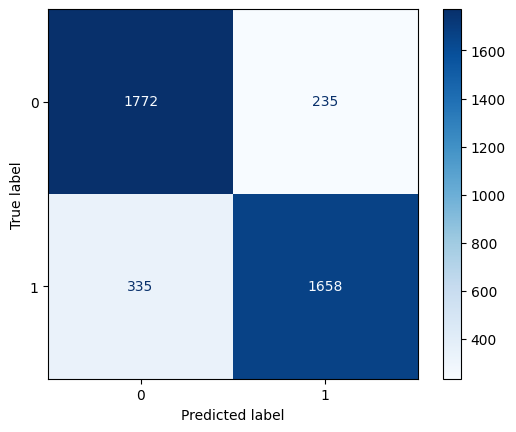

In [11]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df, y_train)
pred_rf = RF.predict(embeddings_x_val_df)
pred_rf_prob = RF.predict_proba(embeddings_x_val_df)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.86 & 0.866 & 0.849 & 0.858 & 0.934 \
{'Accuracy': 0.8595, 'Precision': 0.8659846547314578, 'Recall': 0.8494731560461616, 'F1 Score': 0.8576494427558258, 'ROC-AUC': 0.9342329443535684}

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2007
           1       0.87      0.85      0.86      1993

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



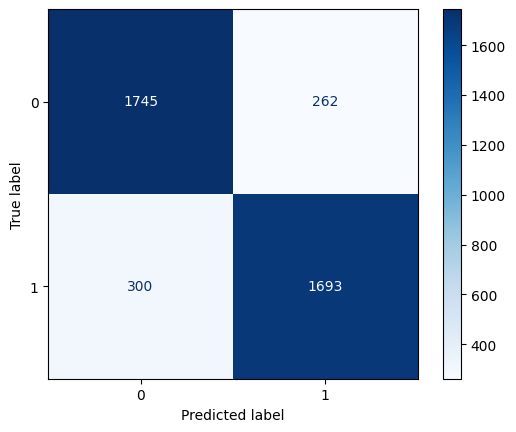

In [12]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)
pred_xgb = xgb_model.predict(embeddings_x_val_df)
pred_xgb_prob = xgb_model.predict_proba(embeddings_x_val_df)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])

# Embeddings 100 dimensions

In [29]:
batch_request_train = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_train.tolist(),
    name_of_request_file = "request_embeddings_train_2_22_11_2024_100_dimensions",
    description_of_request = "request_embeddings_train_2_22_11_2024_100_dimensions",
    dimensions = 100
)
print(batch_request_train)

Batch(id='batch_6740d31921d48190b16cdad8fb7bcb73', completion_window='24h', created_at=1732301593, endpoint='/v1/embeddings', input_file_id='file-7c5obWZnlEZEHtQmYb6cMPGV', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1732387993, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_train_2_10_11_2024_100_dimensions'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [67]:
print(client.batches.retrieve("batch_6740d31921d48190b16cdad8fb7bcb73"))

Batch(id='batch_6740d31921d48190b16cdad8fb7bcb73', completion_window='24h', created_at=1732301593, endpoint='/v1/embeddings', input_file_id='file-7c5obWZnlEZEHtQmYb6cMPGV', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1732312671, error_file_id=None, errors=None, expired_at=None, expires_at=1732387993, failed_at=None, finalizing_at=1732308930, in_progress_at=1732301598, metadata={'description': 'request_embeddings_train_2_10_11_2024_100_dimensions'}, output_file_id='file-7puHgrsquyVxeAAqfGcKGq', request_counts=BatchRequestCounts(completed=32000, failed=0, total=32000))


In [68]:
embeddings_x_train_df = save_embeddings_to_file_and_get_predictions(
    result_file_id="file-7puHgrsquyVxeAAqfGcKGq",
    result_file_name="batch_result_train_22_11_2024_100_dimensions"
)
len(embeddings_x_train_df[0])

32000it [00:01, 20201.71it/s]


100

In [77]:
batch_request_val = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_val.tolist(),
    name_of_request_file = "request_embeddings_val_3_23_11_2024_100_dimensions",
    description_of_request = "request_embeddings_val_3_23_11_2024_100_dimensions",
    dimensions = 100
)
print(batch_request_val)

Batch(id='batch_6741b92c4ffc819085c4390dd2509524', completion_window='24h', created_at=1732360492, endpoint='/v1/embeddings', input_file_id='file-Gr6vV2fPdfECHe9oMUXTb5', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1732446892, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_val_3_23_11_2024_100_dimensions'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [81]:
print(client.batches.retrieve("batch_6741b92c4ffc819085c4390dd2509524"))

Batch(id='batch_6741b92c4ffc819085c4390dd2509524', completion_window='24h', created_at=1732360492, endpoint='/v1/embeddings', input_file_id='file-Gr6vV2fPdfECHe9oMUXTb5', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1732364271, error_file_id=None, errors=None, expired_at=None, expires_at=1732446892, failed_at=None, finalizing_at=1732363928, in_progress_at=1732360493, metadata={'description': 'request_embeddings_val_3_23_11_2024_100_dimensions'}, output_file_id='file-ULG1Af7ECBWZy3jLQ4wHcD', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))


In [82]:
embeddings_x_val_df = save_embeddings_to_file_and_get_predictions(
    result_file_id="file-ULG1Af7ECBWZy3jLQ4wHcD",
    result_file_name="batch_result_3_val_22_11_2024_100_dimensions"
)
len(embeddings_x_val_df[0])

4000it [00:00, 21506.80it/s]


100

0.822 & 0.827 & 0.813 & 0.82 & 0.901 \
{'Accuracy': 0.8225, 'Precision': 0.8274629913221031, 'Recall': 0.8133467134972403, 'F1 Score': 0.820344129554656, 'ROC-AUC': 0.9011867895381718}

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2007
           1       0.83      0.81      0.82      1993

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



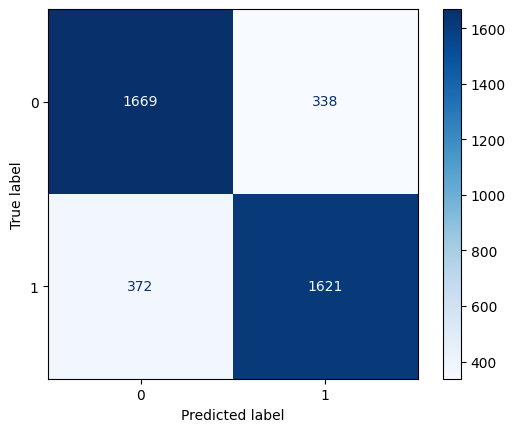

In [83]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df, y_train)
pred_rf = RF.predict(embeddings_x_val_df)
pred_rf_prob = RF.predict_proba(embeddings_x_val_df)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.819 & 0.82 & 0.816 & 0.818 & 0.901 \
{'Accuracy': 0.81875, 'Precision': 0.8195564516129032, 'Recall': 0.8158554942298043, 'F1 Score': 0.8177017852652754, 'ROC-AUC': 0.9012164149010825}

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2007
           1       0.82      0.82      0.82      1993

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



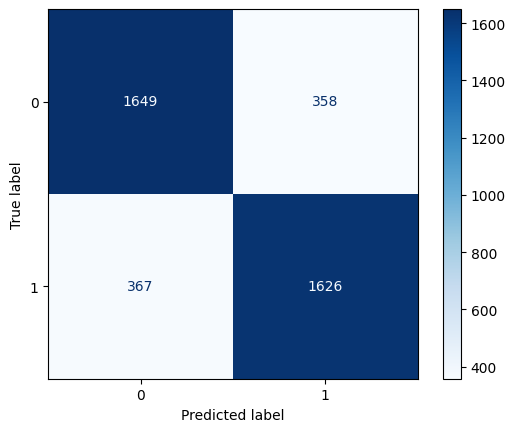

In [84]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)
pred_xgb = xgb_model.predict(embeddings_x_val_df)
pred_xgb_prob = xgb_model.predict_proba(embeddings_x_val_df)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])

# 30 dimennsions

In [87]:
batch_request_train = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_train.tolist(),
    name_of_request_file = "request_embeddings_train_2_22_11_2024_30_dimensions",
    description_of_request = "request_embeddings_train_2_22_11_2024_30_dimensions",
    dimensions = 30
)
print(batch_request_train)

Batch(id='batch_6741d861138c8190aa23a76f49cd58a1', completion_window='24h', created_at=1732368481, endpoint='/v1/embeddings', input_file_id='file-6bGeAjF1BMbhB3CU8u687K', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1732454881, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'request_embeddings_train_2_22_11_2024_30_dimensions'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [100]:
print(client.batches.retrieve("batch_6741d861138c8190aa23a76f49cd58a1"))

Batch(id='batch_6741d861138c8190aa23a76f49cd58a1', completion_window='24h', created_at=1732368481, endpoint='/v1/embeddings', input_file_id='file-6bGeAjF1BMbhB3CU8u687K', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1732383410, error_file_id=None, errors=None, expired_at=None, expires_at=1732454881, failed_at=None, finalizing_at=1732377445, in_progress_at=1732368488, metadata={'description': 'request_embeddings_train_2_22_11_2024_30_dimensions'}, output_file_id='file-QsVSrvpiviweyZJxeW67j4', request_counts=BatchRequestCounts(completed=32000, failed=0, total=32000))


In [101]:
embeddings_x_train_df = save_embeddings_to_file_and_get_predictions(
    result_file_id="file-QsVSrvpiviweyZJxeW67j4",
    result_file_name="batch_result_train_23_11_2024_30_dimensions"
)
len(embeddings_x_train_df[0])

32000it [00:03, 9791.78it/s] 


30

In [ ]:
batch_request_val = create_batch_request_to_open_ai_embeddings(
    list_of_texts = x_val.tolist(),
    name_of_request_file = "request_embeddings_val_3_23_11_2024_30_dimensions",
    description_of_request = "request_embeddings_val_3_23_11_2024_30_dimensions",
    dimensions = 30
)
print(batch_request_val)

In [ ]:
print(client.batches.retrieve("batch_6741d8698d94819083706703a9878c9a"))

In [ ]:
embeddings_x_val_df = save_embeddings_to_file_and_get_predictions(
    result_file_id="file-8Ywrg3fHRP5bLmjdoXrin5",
    result_file_name="batch_result_3_val_22_11_2024_30_dimensions"
)
len(embeddings_x_val_df[0])

0.788 & 0.788 & 0.787 & 0.787 & 0.862 \
{'Accuracy': 0.78825, 'Precision': 0.7876506024096386, 'Recall': 0.787255393878575, 'F1 Score': 0.7874529485570892, 'ROC-AUC': 0.8615838044016039}

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2007
           1       0.79      0.79      0.79      1993

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



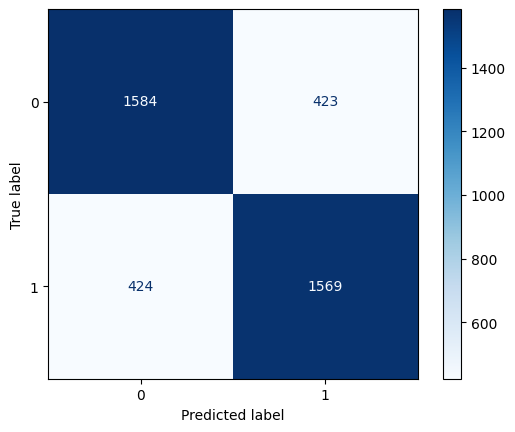

In [103]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df, y_train)
pred_rf = RF.predict(embeddings_x_val_df)
pred_rf_prob = RF.predict_proba(embeddings_x_val_df)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.783 & 0.783 & 0.781 & 0.782 & 0.857 \
{'Accuracy': 0.78325, 'Precision': 0.783484390735146, 'Recall': 0.7807325639739087, 'F1 Score': 0.7821060567981906, 'ROC-AUC': 0.8570787492146777}

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      2007
           1       0.78      0.78      0.78      1993

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



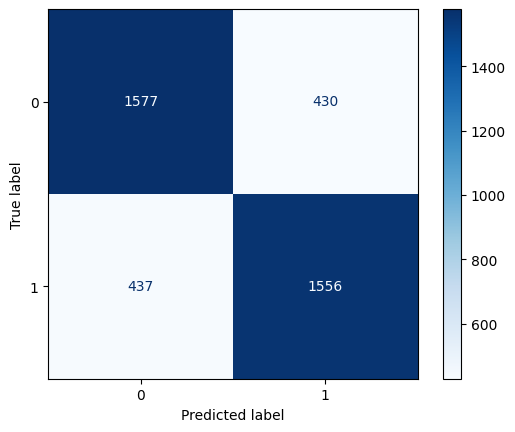

In [104]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)
pred_xgb = xgb_model.predict(embeddings_x_val_df)
pred_xgb_prob = xgb_model.predict_proba(embeddings_x_val_df)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])

In [85]:
#Summary -> graphs

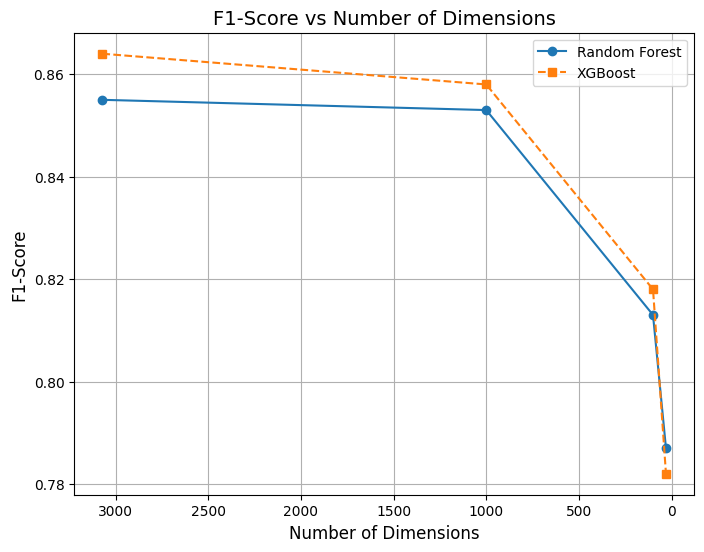

In [106]:
import matplotlib.pyplot as plt

# Data for the plot
dimensions = [3072, 1000, 100, 30]
f1_random_forest = [0.855, 0.853, 0.813, 0.787]
f1_xgboost = [0.864, 0.858, 0.818, 0.782]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(dimensions, f1_random_forest, marker='o', label='Random Forest', linestyle='-')
plt.plot(dimensions, f1_xgboost, marker='s', label='XGBoost', linestyle='--')

# Adding labels and title
plt.xlabel('Number of Dimensions', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('F1-Score vs Number of Dimensions', fontsize=14)
plt.gca().invert_xaxis()  # Invert x-axis for a clearer decreasing trend
plt.legend()
plt.grid(True)

plt.savefig('f1_score_vs_dimensions.png')
# Show the plot
plt.show()